In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from tqdm import tqdm
from datasets import load_dataset

import torchvision.models as models
import torch
from torchvision import transforms
import torchvision.models as models
from torch.autograd import Variable

from utils.snack_dataset import SnackDataset
from utils.hue_histogram import hue_histogram
from utils.create_hog import HOG

style.use('ggplot')


n_bins = 1600

# Load pre-trained ResNet-50
model = models.resnet50(pretrained=True)
layer = model._modules.get('avgpool')
model.eval()  # Set the model to evaluation mode

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

# embeddings function
def get_embedding(img):
    img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # Resnet 50 avg pool layer expects 2048 x 1 x 1
    embedding = torch.zeros(2048)

    def copy_data(m, i, o):
        embedding.copy_(o.data.squeeze())

    h = layer.register_forward_hook(copy_data)
    model(img)
    h.remove()

    return embedding

# Load the dataset
snacks = SnackDataset()

train_imgs = list(snacks.get_train_set())

snacks = load_dataset("Matthijs/snacks")
train_snacks = snacks["train"]

# # Get ResNet embeddings
train_embeddings = []
for i in tqdm(range(len(train_snacks))):
    embedding = get_embedding(train_snacks[i]["image"])
    # flatten and convert to numpy
    train_embeddings.append(embedding.detach().numpy().flatten())

# Get Hue Histogram features
print('Extracting Hue Histogram features...')
hue_features = np.array([hue_histogram(img, bins=n_bins) for img, _ in tqdm(train_imgs)])

# Get HOG features
hog_features = np.array([HOG(img).hog_image_rescaled.flatten() for img, _ in tqdm(train_imgs)])

/Users/zukangy/Desktop/projects/281_computer_vision_assignments/.env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zukangy/Desktop/projects/281_computer_vision_assignments/.env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 4838/4838 [02:45<00:00, 29.24it/s]


Extracting Hue Histogram features...


100%|██████████| 4838/4838 [01:56<00:00, 41.38it/s]


In [3]:
# map label to vocab
label_vocab = {0: "apple",1:"banana",2:"cake",3:"candy",4:"carrot",5:"cookie",6:"doughbut",
7:"grape",8:"hotdog",9:"icecream",10:"juice",11:"muffin",12:"orange",13:"pineapple",14:"popcorn",
15:"pretzel",16:"salad",17:"strawberry",18:"waffle",19:"watermelon"}

labels = [label for _, label in train_imgs]
mapped_labels = [label_vocab[label] for label in labels]

# t-SNE and plotting for Hue Histogram features
tsne_hue = TSNE(n_components=2, random_state=1)
X_2d_hue = tsne_hue.fit_transform(hue_features)

# t-SNE and plotting for HOG features
tsne_hog = TSNE(n_components=2, random_state=1)
X_2d_hog = tsne_hog.fit_transform(hog_features)

# t-SNE and plotting for ResNet embeddings
tsne_resnet = TSNE(n_components=2, random_state=1)
X_2d_resnet = tsne_resnet.fit_transform(np.array(train_embeddings))


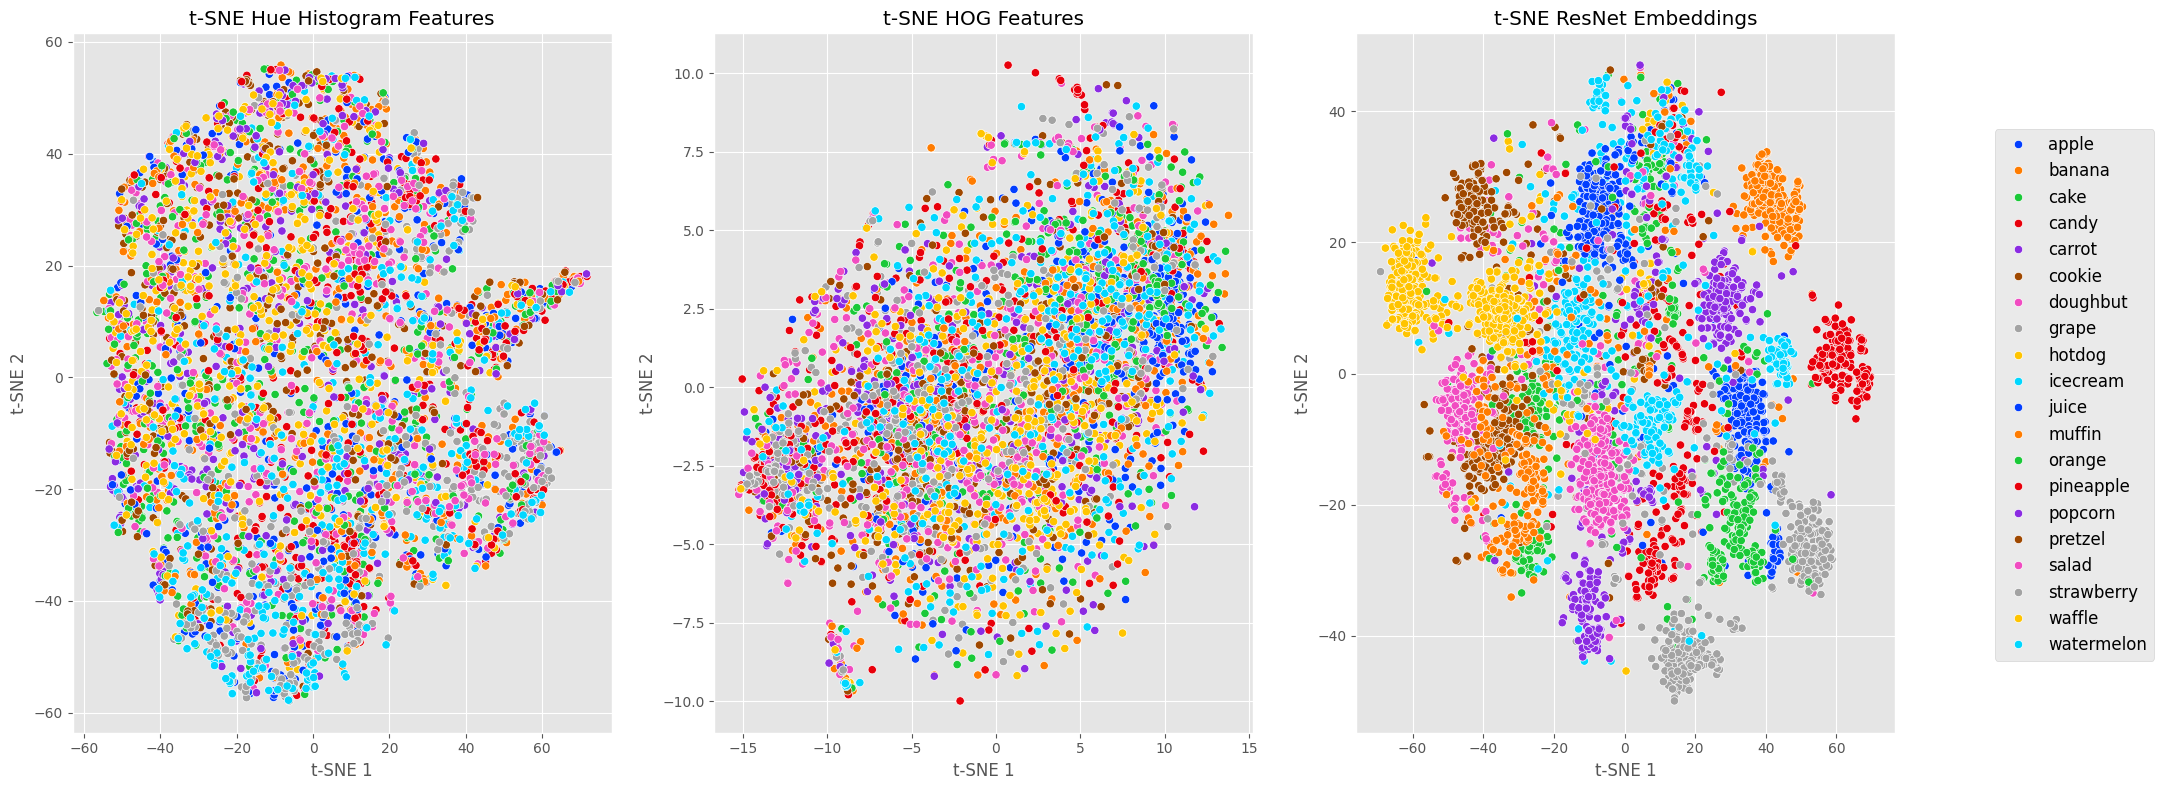

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))  # 1 row, 3 columns

sns.scatterplot(x=X_2d_hue[:,0], y=X_2d_hue[:,1], hue=mapped_labels, ax=axes[0], \
                legend=False,palette='bright')
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")
axes[0].set_title('t-SNE Hue Histogram Features')

sns.scatterplot(x=X_2d_hog[:,0], y=X_2d_hog[:,1], hue=mapped_labels, ax=axes[1],\
                legend=False,palette='bright')
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")
axes[1].set_title('t-SNE HOG Features')

sns.scatterplot(x=X_2d_resnet[:,0], y=X_2d_resnet[:,1], hue=mapped_labels, ax=axes[2],\
                palette='bright')
axes[2].set_xlabel("t-SNE 1")
axes[2].set_ylabel("t-SNE 2")
axes[2].set_title('t-SNE ResNet Embeddings')

axes[2].get_legend().remove()

handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), 
           fontsize='large', borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.85, 1])
fig.subplots_adjust(right=0.95)

plt.show()